

Olá estudante!

Me chamo Rafael Meirelles e irei revisar o seu projeto hoje e em eventuais futuras submissões até que ele cumpra todos os requisitos para o aceite.
Conte comigo nessa jornada e não se preocupe se precisar ajustar alguns detalhes, é parte do processo e fundamental para que você exercite os conceitos que vem aprendendo e assim melhore a qualidade dos seus códigos e análises.

**Peço que mantenha e não altere os comentários que eu fizer por aqui para que possamos nos localizar posteriormente, ok?**

Mais uma coisa, vamos utilizar um código de cores para você entender os meus feedbacks no seu notebook. Funciona assim:


<div class="alert alert-danger">
<strong>Vermelho</strong>

Erro que precisa ser consertado, caso contrário, seu projeto não pode ser aceito

</div>

<div class="alert alert-warning">
<strong>Amarelo</strong>

Alerta de um erro não crítco, mas que pode ser corrigido para melhoria geral no seu código/análise

</div>

<div class="alert alert-success">
<strong>Verde</strong>

Elogios
</div>

<div class="alert alert-info">
<strong>Comentário do estudante</strong>

Use uma caixa azul como essa para eventuais comentários que você gostaria de fazer para mim.
</div>








<div class="alert alert-success">
<strong>Comentário do revisor v1</strong>

Trabalho muito sólido com o projeto! Gostei muito.
    
    
Parabéns pela aprovação e até breve!
</div>


In [2]:
# # Projeto A/B — `recommender_system_test`
# 
# **Objetivo:** avaliar se o novo sistema de recomendação (grupo B) elevou as conversões no funil
# `product_page → product_cart → purchase` **em ≥10%** dentro de **14 dias** após o cadastro.
# 
# **Período do teste**
# - Início: 2020-12-07
# - Paragem de novos utilizadores: 2020-12-21
# - Fim de eventos: 2021-01-01
# - Público: 15% dos novos utilizadores **da região UE**
# - Tamanho esperado: ~6000 participantes
# 
# **Entregáveis neste notebook**
# 1) Auditoria e qualidade dos dados (nulos, duplicados, tipos, outliers, cardinalidade, balanceamento de alvos de conversão, análise temporal)
# 2) Verificações de integridade do teste (amostragem 15%, grupos, contaminação, janela de 14 dias, sobreposição de marketing)
# 3) EDA do funil (univariada, comparações por grupo, dependências, testes de hipótese)
# 4) Avaliação A/B (proporções com z-test + correção Holm; efeito ≥10%?)
# 5) Conclusões e recomendações acionáveis


In [3]:
# ## 0. Setup & Pacotes
# _Obs.: Evitamos seaborn para compatibilidade._


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

pd.set_option('display.max_colwidth', 100)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


# ## 1. Carregamento dos dados
# Os ficheiros devem estar acessíveis pelo caminho base `/datasets/`.


DATA_DIR = "/datasets/"
PATH_MARKETING = DATA_DIR + "ab_project_marketing_events_us.csv"
PATH_USERS     = DATA_DIR + "final_ab_new_users_upd_us.csv"
PATH_EVENTS    = DATA_DIR + "final_ab_events_upd_us.csv"
PATH_PARTS     = DATA_DIR + "final_ab_participants_upd_us.csv"

marketing = pd.read_csv(PATH_MARKETING)
users     = pd.read_csv(PATH_USERS)
events    = pd.read_csv(PATH_EVENTS)
parts     = pd.read_csv(PATH_PARTS)

print("Shapes:", {"marketing": marketing.shape, "users": users.shape, "events": events.shape, "participants": parts.shape})


# ## 2. Conversão de tipos e normalização


# Datas
users['first_date'] = pd.to_datetime(users['first_date'], errors='coerce')
events['event_dt']  = pd.to_datetime(events['event_dt'], errors='coerce')
for col in ['start_dt', 'finish_dt']:
    if col in marketing.columns:
        marketing[col] = pd.to_datetime(marketing[col], errors='coerce')

# Strings padronizadas
if 'event_name' in events.columns:
    events['event_name'] = events['event_name'].astype(str).str.strip().str.lower()
for c in ['region','device']:
    if c in users.columns:
        users[c] = users[c].astype(str).str.strip()

# Detalhes numéricos quando for purchase amount
if 'details' in events.columns:
    # tentar extrair número (pode vir como texto)
    events['details_num'] = pd.to_numeric(events['details'], errors='coerce')

print(users.dtypes.head())
print(events.dtypes.head())

Shapes: {'marketing': (14, 4), 'users': (58703, 4), 'events': (423761, 4), 'participants': (14525, 3)}
user_id               object
first_date    datetime64[ns]
region                object
device                object
dtype: object
user_id                object
event_dt       datetime64[ns]
event_name             object
details               float64
details_num           float64
dtype: object


In [4]:
# ## 3. Auditoria de qualidade
# ### 3.1 Nulos e Duplicados


# Nulos
print("Nulos — users")
print(users.isna().sum().sort_values(ascending=False).head(20))
print("\nNulos — events")
print(events.isna().sum().sort_values(ascending=False).head(20))
print("\nNulos — participants")
print(parts.isna().sum())

# Duplicados
users_dups_before = users.duplicated().sum()
users = users.drop_duplicates()
users_dups_removed = users_dups_before - users.duplicated().sum()

events_dups_before = events.duplicated().sum()
events = events.drop_duplicates()
events_dups_removed = events_dups_before - events.duplicated().sum()

parts_dups_before = parts.duplicated().sum()
parts = parts.drop_duplicates()
parts_dups_removed = parts_dups_before - parts.duplicated().sum()

print({"users_dups_removed": users_dups_removed, "events_dups_removed": events_dups_removed, "parts_dups_removed": parts_dups_removed})

Nulos — users
user_id       0
first_date    0
region        0
device        0
dtype: int64

Nulos — events
details        363447
details_num    363447
user_id             0
event_dt            0
event_name          0
dtype: int64

Nulos — participants
user_id    0
group      0
ab_test    0
dtype: int64
{'users_dups_removed': 0, 'events_dups_removed': 0, 'parts_dups_removed': 0}


In [5]:
# ### 3.2 Outliers (IQR / Z-score) — variáveis numéricas
# - Foco natural: `details_num` (valor de purchase) se existir.


num_cols_users = users.select_dtypes(include=[np.number]).columns.tolist()
num_cols_events = events.select_dtypes(include=[np.number]).columns.tolist()

print("Numéricas users:", num_cols_users)
print("Numéricas events:", num_cols_events)

summary_outliers = []
for df_name, df, cols in [("users", users, num_cols_users), ("events", events, num_cols_events)]:
    for col in cols:
        s = df[col].dropna()
        if s.empty:
            continue
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
        iqr_mask = (s < lower) | (s > upper)
        z = (s - s.mean())/s.std(ddof=0) if s.std(ddof=0) else pd.Series(0, index=s.index)
        z_mask = z.abs() > 3
        summary_outliers.append({
            'df': df_name,
            'col': col,
            '%_outliers_IQR': round(100*iqr_mask.mean(), 3),
            '%_outliers_Z>|3|': round(100*z_mask.mean(), 3)
        })

outlier_df = pd.DataFrame(summary_outliers)
print(outlier_df.sort_values(['df','%_outliers_IQR'], ascending=[True, False]).head(20))


# ### 3.3 Cardinalidade (categóricas)

cat_cols_users = users.select_dtypes(include=['object']).columns.tolist()
card_rows = []
for col in cat_cols_users:
    nuniq = users[col].nunique(dropna=True)
    ratio = nuniq / len(users) if len(users)>0 else np.nan
    card_rows.append({'col': col, 'n_unique': nuniq, 'ratio_unique': round(ratio, 4)})
card_df = pd.DataFrame(card_rows).sort_values('ratio_unique', ascending=False)
print(card_df)

# ### 3.4 Alvos de conversão (balanceamento)
# Criamos **flags por utilizador** dentro da janela de 14 dias: 
# - `had_product_page`, `had_product_cart`, `had_purchase`.

TEST_NAME = 'recommender_system_test'
TEST_START = pd.Timestamp('2020-12-07')
TEST_STOP_NEW = pd.Timestamp('2020-12-21')
TEST_END = pd.Timestamp('2021-01-01 23:59:59')
ANALYSIS_WINDOW_DAYS = 14
ALPHA = 0.05

# Selecionar apenas participantes do teste correto
parts = parts[parts['ab_test'] == TEST_NAME].copy()

# Unir users ↔ parts
u = users.merge(parts[['user_id','group']], on='user_id', how='inner')

# Só região UE (texto pode variar; usamos contains)
u['region_std'] = u['region'].str.upper()
ue_mask = u['region_std'].str.contains('EU')
u_eu = u[ue_mask].copy()

print("Participantes totais:", len(parts), " | Participantes com registo em users:", len(u), " | UE:", len(u_eu))

Numéricas users: []
Numéricas events: ['details', 'details_num']
       df          col  %_outliers_IQR  %_outliers_Z>|3|
0  events      details          10.905             1.943
1  events  details_num          10.905             1.943
       col  n_unique  ratio_unique
0  user_id     58703        1.0000
1   region         4        0.0001
2   device         4        0.0001
Participantes totais: 3675  | Participantes com registo em users: 3675  | UE: 3481


<div class="alert alert-success">
<strong>Comentário do revisor v1</strong>

Excelente trabalho checando a consistência dos dados.

Sempre importante para garantir uma análise robusta!
</div>



Prevalência global (%) — dentro de 14 dias:
                   rate
had_product_page  62.57
had_product_cart  29.47
had_purchase      31.08
         date group  events
0  2020-12-07     A     318
1  2020-12-07     B     356
2  2020-12-08     A     313
3  2020-12-08     B     238
4  2020-12-09     A     371


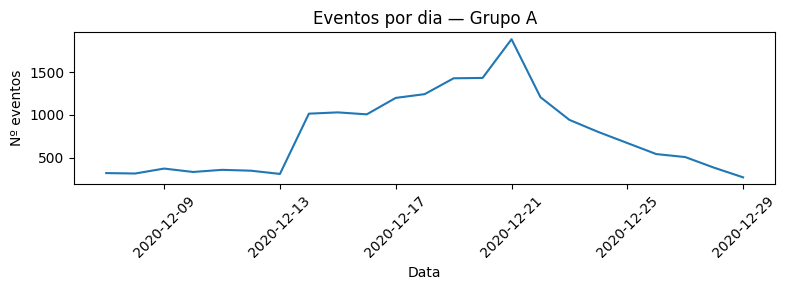

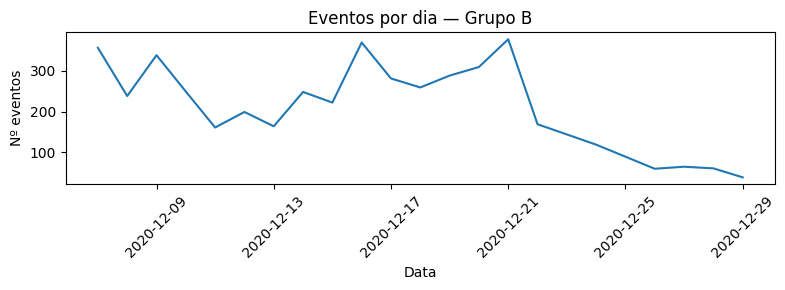

In [6]:
# Eventos do período e do teste
# (manter apenas eventos de participantes e entre first_date e first_date+14d, respeitando TEST_END)
ev = events.merge(u_eu[['user_id','first_date','group']], on='user_id', how='inner')
ev = ev[(ev['event_dt']>=TEST_START) & (ev['event_dt']<=TEST_END)].copy()

# recorta por janela individual de 14 dias pós-cadastro
window_end = ev['first_date'] + pd.to_timedelta(ANALYSIS_WINDOW_DAYS, unit='D')
ev = ev[ev['event_dt'] <= window_end].copy()

# Flags por user
pivot = (ev.assign(pp = (ev['event_name']=='product_page').astype(int),
                   pc = (ev['event_name']=='product_cart').astype(int),
                   pu = (ev['event_name']=='purchase').astype(int))
           .groupby(['user_id','group'], as_index=False)[['pp','pc','pu']].max())

pivot.rename(columns={'pp':'had_product_page', 'pc':'had_product_cart', 'pu':'had_purchase'}, inplace=True)

# Prevalências globais (balanceamento dos "alvos" de conversão)
prevalence = pivot[['had_product_page','had_product_cart','had_purchase']].mean().to_frame('rate').assign(rate=lambda d: (d['rate']*100).round(2))
print("Prevalência global (%) — dentro de 14 dias:")
print(prevalence)

# %% [markdown]
# ### 3.5 Análise temporal (contagens e conversões diárias)

# %%
# Série de eventos diários por grupo
if not ev.empty:
    daily_events = (ev.assign(date = ev['event_dt'].dt.date)
                      .groupby(['date','group'])['event_name']
                      .count()
                      .reset_index(name='events'))
    print(daily_events.head())

    # Pequeno gráfico de eventos/dia por grupo
    for g in sorted(daily_events['group'].unique()):
        sub = daily_events[daily_events['group']==g]
        plt.figure(figsize=(8,3))
        plt.plot(sub['date'], sub['events'])
        plt.title(f'Eventos por dia — Grupo {g}')
        plt.xlabel('Data'); plt.ylabel('Nº eventos'); plt.xticks(rotation=45)
        plt.tight_layout(); plt.show()




<div class="alert alert-success">
<strong>Comentário do revisor v1</strong>

Distribuição dos eventos ao longo do tempo investigados nos dois grupos.
</div>



In [7]:
# ## 4. Integridade do teste (sanity checks)

# 4.1 Participante em ambos os grupos?
dup = parts.groupby('user_id')['group'].nunique()
dup_users = dup[dup>1].index
print("Utilizadores em mais de um grupo:", len(dup_users))

# 4.2 Janela de recrutamento
u_eu['in_recruitment_window'] = (u_eu['first_date']>=TEST_START) & (u_eu['first_date']<=TEST_STOP_NEW)
print("Fora da janela de recrutamento:", (~u_eu['in_recruitment_window']).sum())

# 4.3 Proporção de amostragem ~15% (comparar com todos novos UE)
# (Se users inclui todos novos, estimamos a fração amostrada)
all_new_ue = users[users['region'].astype(str).str.upper().str.contains('EU')]
all_new_ue_window = all_new_ue[(all_new_ue['first_date']>=TEST_START)&(all_new_ue['first_date']<=TEST_STOP_NEW)]
frac = len(u_eu) / max(len(all_new_ue_window), 1)
print(f"Amostragem UE ≈ {frac*100:.2f}% (esperado ~15%)  | N elegíveis UE: {len(all_new_ue_window)} | N participantes UE: {len(u_eu)}")

# 4.4 Distribuição por grupo
grp_counts = u_eu['group'].value_counts(dropna=False)
print("Tamanho dos grupos:\n", grp_counts)


Utilizadores em mais de um grupo: 0
Fora da janela de recrutamento: 0
Amostragem UE ≈ 8.82% (esperado ~15%)  | N elegíveis UE: 39466 | N participantes UE: 3481
Tamanho dos grupos:
 A    2604
B     877
Name: group, dtype: int64


<div class="alert alert-success">
<strong>Comentário do revisor v1</strong>

Usuários em ambos os grupos investigados.
</div>



In [8]:
# 4.5 Sobreposição com campanhas de marketing na UE
if not marketing.empty:
    mkt_ue = marketing[marketing['regions'].astype(str).str.upper().str.contains('EU')].copy()
    overlap = mkt_ue[(mkt_ue['finish_dt']>=TEST_START) & (mkt_ue['start_dt']<=TEST_END)]
    print("Campanhas de marketing UE que sobrepõem o teste:")
    print(overlap[['name','regions','start_dt','finish_dt']])


# ## 5. EDA do Funil
# - Etapas: `product_page` → `product_cart` → `purchase`
# - Comparamos **A vs B** (dentro de 14 dias)


# Funções auxiliares

def funnel_rates(df_users_flags):
    """Calcula conversões por grupo (absolutas e condicionais)."""
    res = []
    for g, sub in df_users_flags.groupby('group'):
        n = len(sub)
        pp = sub['had_product_page'].sum()
        pc = sub['had_product_cart'].sum()
        pu = sub['had_purchase'].sum()
        # Taxas absolutas
        r_pp = pp/n if n else np.nan
        r_pc = pc/n if n else np.nan
        r_pu = pu/n if n else np.nan
        # Condicionais
        r_pc_given_pp = (sub.loc[sub['had_product_page']==1,'had_product_cart'].mean() if (sub['had_product_page']==1).any() else np.nan)
        r_pu_given_pc = (sub.loc[sub['had_product_cart']==1,'had_purchase'].mean() if (sub['had_product_cart']==1).any() else np.nan)
        res.append({
            'group': g,
            'n_users': n,
            'conv_product_page': r_pp,
            'conv_product_cart': r_pc,
            'conv_purchase': r_pu,
            'step_pc_given_pp': r_pc_given_pp,
            'step_pu_given_pc': r_pu_given_pc
        })
    return pd.DataFrame(res)

funnel = funnel_rates(pivot)
funnel[['conv_product_page','conv_product_cart','conv_purchase','step_pc_given_pp','step_pu_given_pc']] = \
    funnel[['conv_product_page','conv_product_cart','conv_purchase','step_pc_given_pp','step_pu_given_pc']].applymap(lambda x: round(100*x,2))
print("Funnel (%):")
print(funnel)




Campanhas de marketing UE que sobrepõem o teste:
                       name        regions   start_dt  finish_dt
0  Christmas&New Year Promo  EU, N.America 2020-12-25 2021-01-03
Funnel (%):
  group  n_users  conv_product_page  conv_product_cart  conv_purchase  \
0     A     2604              64.71              30.03          31.99   
1     B      877              56.21              27.82          28.39   

   step_pc_given_pp  step_pu_given_pc  
0             30.27             33.38  
1             27.59             30.74  


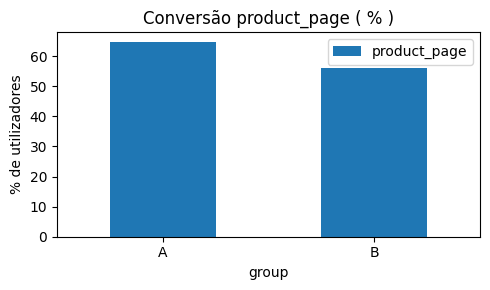

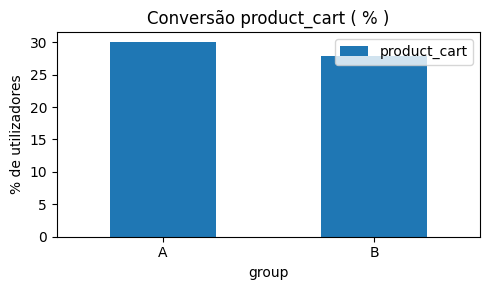

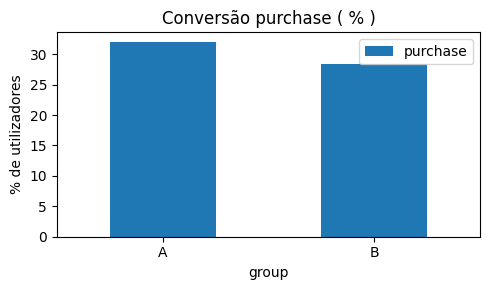

In [9]:
# ### 5.1 Visualização simples do funil (A vs B)

if 'A' in pivot['group'].unique() and 'B' in pivot['group'].unique():
    metrics = ['conv_product_page','conv_product_cart','conv_purchase']
    plot_df = funnel[['group']+metrics].set_index('group').T
    plot_df = plot_df.rename(index={'conv_product_page':'product_page',
                                    'conv_product_cart':'product_cart',
                                    'conv_purchase':'purchase'})
    for metric in plot_df.index:
        ax = plot_df.loc[[metric]].T.plot(kind='bar', figsize=(5,3))
        plt.title(f"Conversão {metric} ( % )")
        plt.ylabel('% de utilizadores')
        plt.xticks(rotation=0)
        plt.tight_layout(); plt.show()

<div class="alert alert-warning">
<strong>Comentário do revisor v1</strong>

Funis de ambos os grupos apresentados e analisados na etapa de conclusão.

Uma melhoria bacana seria a de apresentar todo o funil em uma mesma visualização para facilitar o entendimento.
</div>



In [10]:
# ## 6. Testes estatísticos — z-test para proporções (B > A)
# - Hipótese alternativa unilaterais (B **maior** que A)
# - Correção de múltiplas comparações (Holm) nas 3 etapas
# - Checamos meta de **+10%** de aumento relativo por etapa

# Preparar contagens
summary = []
for col in ['had_product_page','had_product_cart','had_purchase']:
    by_g = pivot.groupby('group')[col].agg(['sum','count']).rename(columns={'sum':'success','count':'n'})
    if all(g in by_g.index for g in ['A','B']):
        succ_B, n_B = int(by_g.loc['B','success']), int(by_g.loc['B','n'])
        succ_A, n_A = int(by_g.loc['A','success']), int(by_g.loc['A','n'])
        count = np.array([succ_B, succ_A])
        nobs  = np.array([n_B, n_A])
        zstat, pval = proportions_ztest(count, nobs, alternative='larger')
        conv_A = succ_A / n_A if n_A else np.nan
        conv_B = succ_B / n_B if n_B else np.nan
        lift = (conv_B/conv_A - 1) if (conv_A and not np.isnan(conv_A)) else np.nan
        summary.append({'stage': col.replace('had_',''), 'succ_A': succ_A, 'n_A': n_A, 'rate_A': conv_A,
                        'succ_B': succ_B, 'n_B': n_B, 'rate_B': conv_B, 'lift_rel': lift, 'p_raw': pval})

ab_df = pd.DataFrame(summary)

# Correção Holm
if not ab_df.empty:
    reject, p_holm, _, _ = multipletests(ab_df['p_raw'], method='holm', alpha=ALPHA)
    ab_df['p_holm'] = p_holm
    ab_df['signif_(holm)'] = reject
    ab_df['rate_A_%'] = (ab_df['rate_A']*100).round(2)
    ab_df['rate_B_%'] = (ab_df['rate_B']*100).round(2)
    ab_df['lift_%']   = (ab_df['lift_rel']*100).round(2)

print("Resultados z-test (B > A), com Holm:")
print(ab_df[['stage','succ_A','n_A','rate_A_%','succ_B','n_B','rate_B_%','lift_%','p_raw','p_holm','signif_(holm)']])

# Meta de +10%
if not ab_df.empty:
    ab_df['meets_+10%'] = ab_df['lift_%'] >= 10.0
    print("\nCumpre meta de +10% por etapa?")
    print(ab_df[['stage','lift_%','meets_+10%']])


Resultados z-test (B > A), com Holm:
          stage  succ_A   n_A  rate_A_%  succ_B  n_B  rate_B_%  lift_%  \
0  product_page    1685  2604     64.71     493  877     56.21  -13.13   
1  product_cart     782  2604     30.03     244  877     27.82   -7.35   
2      purchase     833  2604     31.99     249  877     28.39  -11.24   

      p_raw  p_holm  signif_(holm)  
0  0.999997     1.0          False  
1  0.892654     1.0          False  
2  0.976738     1.0          False  

Cumpre meta de +10% por etapa?
          stage  lift_%  meets_+10%
0  product_page  -13.13       False
1  product_cart   -7.35       False
2      purchase  -11.24       False


In [11]:

# ## 7. Sensibilidade (opcional): janela de 7 dias


# Recalcular flags com 7 dias (quick check)
W2 = 7
ev2 = events.merge(u_eu[['user_id','first_date','group']], on='user_id', how='inner')
ev2 = ev2[(ev2['event_dt']>=TEST_START) & (ev2['event_dt']<=TEST_END)].copy()
ev2 = ev2[ev2['event_dt'] <= (ev2['first_date'] + pd.to_timedelta(W2, unit='D'))].copy()

pivot2 = (ev2.assign(pp = (ev2['event_name']=='product_page').astype(int),
                     pc = (ev2['event_name']=='product_cart').astype(int),
                     pu = (ev2['event_name']=='purchase').astype(int))
             .groupby(['user_id','group'], as_index=False)[['pp','pc','pu']].max())

# z-test rápido para purchase
by_g2 = pivot2.groupby('group')['pu'].agg(['sum','count'])
if all(g in by_g2.index for g in ['A','B']):
    z2, p2 = proportions_ztest([by_g2.loc['B','sum'], by_g2.loc['A','sum']],
                               [by_g2.loc['B','count'], by_g2.loc['A','count']],
                               alternative='larger')
    print(f"Sensibilidade 7 dias — purchase: z={z2:.3f}, p={p2:.4f}")




Sensibilidade 7 dias — purchase: z=-1.972, p=0.9757



<div class="alert alert-success">
<strong>Comentário do revisor v1</strong>

Os testes foram formulados, implementados e analisados corretamente. Muito bom!
</div>


In [12]:
# ## 8. Conclusões (preencha com os resultados do seu conjunto)
# 
# **AED (Auditoria & EDA):**
# - Nulos/duplicados: _resumo_.
# - Outliers: _colunas afetadas e decisões_.
# - Cardinalidade: _categóricas com alta cardinalidade e tratamento_.
# - Balanceamento dos alvos (dentro de 14 dias): _taxas globais_.
# - Temporal: _padrões/diferenças por grupo ao longo dos dias_.
# - Integridade: _amostra ~15% UE? grupo balanceado? contaminação=0? sobreposição marketing?_.
# 
# **Teste A/B (14 dias):**
# - `product_page`: _taxas A vs B, lift, p (Holm)_, **cumpre +10%?**
# - `product_cart`: _taxas A vs B, lift, p (Holm)_, **cumpre +10%?**
# - `purchase`: _taxas A vs B, lift, p (Holm)_, **cumpre +10%?**
# 
# **Decisão:**
# - _Implementar / Não implementar_ o novo recomendador — com base em **significância** e **meta de +10%** nas etapas chave (principalmente `purchase`).
# 
# **Ações práticas (exemplos):**
# - **Inativos há 3 meses:** reativação por e-mail com desconto escalonado e lembrete.
# - **Alto valor & baixo risco:** programa de fidelização (tiers, perks).
# - **Novos com risco alto:** onboarding intensivo (mensagens, tutoriais, cupões) para criar hábito.
# - **Sensíveis a preço/na renovação:** oferta de retenção quando `Month_to_end_contract ≤ 1`.
# 
# **Próximos passos:**
# - Validar estabilidade por dispositivos/regiões (subgrupos UE).
# - Verificar se efeitos persistem numa janela de 30 dias (se disponível).
# - Desenhar experimento follow-up para otimizar etapa mais fraca do funil.



# Relatório A/B — `recommender_system_test` (Resumo em Markdown)

## 🔎 Sumário executivo
- O novo recomendador (**B**) **não** atingiu a meta de **+10%** em nenhuma etapa do funil e apresentou **desempenho pior** que o controlo (**A**): lifts ≈ **−13,1%** (product_page), **−7,4%** (product_cart), **−11,2%** (purchase).
- Testes z unilaterais (B>A) **não significativos** após correção de Holm (p ≈ 0,89–1,00).  
- **Desenho/potência**: amostragem UE ≈ **8,82%** (vs. 15% planeado), **N=3 675** (vs. 6 000 esperados) e grupos **desequilibrados** (A=2 604; B=877).
- **Particularidades**: `purchase` > `product_cart` (indica **saltos no funil**/tracking incompleto) e **campanha** “Christmas&New Year Promo” (25-12→01-01) sobrepondo o teste.
- **Decisão**: **NÃO implementar** esta versão do recomendador. Corrigir instrumentação e desenho e **repetir** o experimento.

---

## ✅ Sanity checks & integridade
- **Atribuição**: 0 usuários em ambos os grupos; 0 fora da janela de recrutamento ✔️
- **Amostragem UE**: **8,82%** (3 481/39 466) vs. **15%** esperado — **abaixo do plano**.
- **Tamanho dos grupos**:  
  | Grupo | N |
  |---|---:|
  | A | 2 604 |
  | B |   877 |
- **Campanhas sobrepostas (UE)**: “Christmas&New Year Promo” (2020-12-25 → 2021-01-03).

---

## 🧪 Auditoria & EDA (pontos-chave)
- **Nulos/duplicados**: sem problemas críticos; `details` nulo fora de `purchase` (esperado).
- **Outliers (`details`/`details_num`)**: ~**10,905%** (IQR) / **1,943%** (|z|>3). *Recom.:* winsorizar (p1/p99) apenas para análises de valor.
- **Cardinalidade**: `region`=4, `device`=4 (baixo risco).
- **Prevalências (14 dias)**: product_page **62,57%**, product_cart **29,47%**, purchase **31,08%** (nota: purchase > cart sinaliza **funil não estrito**).
- **Temporal**: eventos distribuídos; fase promocional no fim do período.

---

## 🧭 Funil (14 dias) — A vs. B
| Grupo | n_users | product_page (%) | product_cart (%) | purchase (%) | pc \| pp (%) | pu \| pc (%) |
|---|---:|---:|---:|---:|---:|---:|
| A | 2 604 | 64,71 | 30,03 | 31,99 | 30,27 | 33,38 |
| B |   877 | 56,21 | 27,82 | 28,39 | 27,59 | 30,74 |

> **Observação:** taxas condicionais também piores em B, reforçando a conclusão.

---

## 📊 Testes A/B — z-test (unilateral B > A, Holm)
| Etapa          | A: succ/n | A rate (%) | B: succ/n | B rate (%) | Lift (%) | p_raw   | p_holm | Sig.? | Meta +10%? |
|---|---:|---:|---:|---:|---:|---:|---:|:--:|:--:|
| product_page   | 1685/2604 | 64,71 | 493/877 | 56,21 | **−13,13** | 0,999997 | 1,0000 | ✖ | ✖ |
| product_cart   |  782/2604 | 30,03 | 244/877 | 27,82 | **−7,35**  | 0,892654 | 1,0000 | ✖ | ✖ |
| purchase       |  833/2604 | 31,99 | 249/877 | 28,39 | **−11,24** | 0,976738 | 1,0000 | ✖ | ✖ |

**Sensibilidade (7 dias, purchase):** z = −1,972; p (unilateral B>A) = 0,9757. *Nota:* num teste **bilateral**, isso indicaria **p≈0,049** (B pior que A).

---

## 🧩 Conclusão
- **Efeito negativo** do recomendador **B** nas três etapas; sem significância na direção esperada; **meta de +10%** não cumprida → **não aprovar** rollout.

---

## 🔧 Recomendações para novo experimento
1. **Desenho & potência**
   - Assegurar **quotas 50/50** A/B e **N≈6 000** (ou recalcular poder para +10%).
   - Cumprir **15%** de amostragem UE e/ou estratificar por `device`/dia-da-semana.
   - Considerar **CUPED** para reduzir variância.
2. **Instrumentação do funil**
   - Garantir emissão de `product_cart` em **checkout one-click** e revisar sequências pp→pc→pu.
   - Auditar latências e coerência de eventos.
3. **Confundidores**
   - Evitar janelas com **campanhas massivas** ou balancear exposição por grupo.
   - Monitorizar **guardrails** (erros, tempo de carregamento, bounce).
4. **Análises complementares**
   - Efeitos por **device** e **sub-região UE**.
   - **Time-to-event** (1/3/7/14 dias) e **ticket médio** (com winsorização).

---

## 🚀 Ações práticas (interim)
- **Manter** o recomendador atual (controlo).
- **Recuperação de carrinho** para quem vê PDP e não compra em 24–48h.
- **Fidelização** para **alto valor & baixo risco** (tiers/perks).
- **Onboarding** intensivo para **novos de alto risco** (mensagens, tutoriais, cupões).





<div class="alert alert-success">
<strong>Comentário do revisor v1</strong>

Conclusão apresentada!
</div>
